In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import statsmodels.api as sm

from utils import *

%load_ext autoreload
%autoreload 2


In [33]:
DATA_PATH = Path("/Users/jessbreda/Desktop/github/ca-sdoh/data")

cols_of_interest = [
    "condition_name",
    "number_of_readmissions",
    "number_of_discharges",
    "avg_payment_amount_py",
    "beneficiary_avg_age",
    "avg_number_white_beneficiaries_py",
    "avg_number_black_beneficiaries_py",
    "avg_number_beneficiaries_medicare_medicaid_py",
    "avg_number_beneficiaries_medicare_only_py",
    "pct_beneficiaries_alzheimers",
    "pct_beneficiaries_cancer",
    "pct_beneficiaries_congestive_heart_failure",
    "pct_beneficiaries_copd",
    "pct_beneficiaries_ischemic_heart_disease",
    "pct_beneficiaries_arthritis",
    "pct_beneficiaries_stroke",
]

df = pd.read_csv(
    (DATA_PATH / "obt_slim.csv"),
    usecols=cols_of_interest,
)

# drop nans
df.dropna(inplace=True)

# calculate readmission rate & drop the original columns
df["readmission_rate"] = (
    df["number_of_readmissions"] / df["number_of_discharges"]
) * 100
df.drop(columns=["number_of_readmissions", "number_of_discharges"], inplace=True)

# right skewed dist -> log transform
log_transform = [
    "avg_payment_amount_py",
    "avg_number_white_beneficiaries_py",
    "avg_number_black_beneficiaries_py",
    "avg_number_beneficiaries_medicare_medicaid_py",
    "avg_number_beneficiaries_medicare_only_py",
]

for col in log_transform:
    df[col] = np.log10(df[col])

In [34]:
model_name = "risk_vars_and_race"
numeric_cols = [
    "avg_payment_amount_py",
    "beneficiary_avg_age",
    "avg_number_white_beneficiaries_py",
    "avg_number_black_beneficiaries_py",
    "avg_number_beneficiaries_medicare_medicaid_py",
    "avg_number_beneficiaries_medicare_only_py",
    "pct_beneficiaries_alzheimers",
    "pct_beneficiaries_cancer",
    "pct_beneficiaries_congestive_heart_failure",
    "pct_beneficiaries_copd",
    "pct_beneficiaries_ischemic_heart_disease",
    "pct_beneficiaries_arthritis",
    "pct_beneficiaries_stroke",
]

cat_cols = ["condition_name"]

X_processed = process_features(df, numeric_cols=numeric_cols, cat_cols=cat_cols)

In [35]:
fit_model, summary_scores = fit_linear_model_sm(
    X_processed,
    df["readmission_rate"],
    model_name=model_name,
    race=True,
    summary_table=None,
)

risk_vars_and_race test mse: 11.733, r2: 0.31


In [5]:
summary_scores

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       readmission_rate   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     178.1
Date:                Mon, 17 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:24:04   Log-Likelihood:                -12988.
No. Observations:                4832   AIC:                         2.601e+04
Df Residuals:                    4816   BIC:                         2.611e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            20.5323      0.095    216.000      0.000      20.346      20.719
avg_payment_amount_py                             1.1453      0.222      5.156      0.000       0.710       1.581
beneficiary_avg_age                              -0.7010      0.088     -7.957      0.000      -0.874      -0.528
avg_number_white_beneficiaries_py                -0.9080      0.220     -4.136      0.000      -1.338      -0.478
avg_number_black_beneficiaries_py                 0.2348      0.085      2.768      0.006       0.068       0.401
avg_number_beneficiaries_medicare_medicaid_py     0.2044      0.149      1.374      0.170      -0.087       0.496
avg_number_beneficiaries_medicare_only_py        -0.8776      0.280     -3.136      0.002      -1.426      -0.329
pct_beneficiaries_alzheimers                      0.5886      0.090      6.574      0.000       0.413       0.764
pct_beneficiaries_cancer                          0.2940      0.077      3.829      0.000       0.143       0.444
pct_beneficiaries_congestive_heart_failure       -0.2608      0.085     -3.063      0.002      -0.428      -0.094
pct_beneficiaries_copd                            0.5827      0.090      6.454      0.000       0.406       0.760
pct_beneficiaries_ischemic_heart_disease          0.3151      0.080      3.949      0.000       0.159       0.471
pct_beneficiaries_arthritis                       0.1737      0.063      2.779      0.005       0.051       0.296
pct_beneficiaries_stroke                          0.2225      0.070      3.191      0.001       0.086       0.359
condition_name_Heart Failure                      1.1074      0.129      8.590      0.000       0.855       1.360
condition_name_Pneumonia                         -3.2572      0.129    -25.320      0.000      -3.509      -3.005
==============================================================================
Omnibus:                      217.114   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              361.862
Skew:                           0.378   Prob(JB):                     2.65e-79
Kurtosis:                       4.108   Cond. No.                         15.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
get_significant_variables(fit_model)

Index(['avg_payment_amount_py', 'beneficiary_avg_age',
       'avg_number_white_beneficiaries_py',
       'avg_number_black_beneficiaries_py',
       'avg_number_beneficiaries_medicare_only_py',
       'pct_beneficiaries_alzheimers', 'pct_beneficiaries_cancer',
       'pct_beneficiaries_congestive_heart_failure', 'pct_beneficiaries_copd',
       'pct_beneficiaries_ischemic_heart_disease',
       'pct_beneficiaries_arthritis', 'pct_beneficiaries_stroke',
       'condition_name_Heart Failure', 'condition_name_Pneumonia'],
      dtype='object')

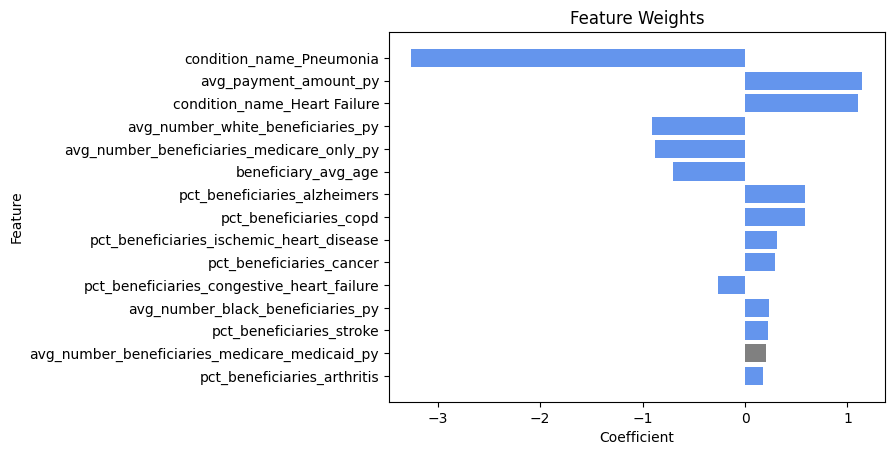

In [7]:
plot_feature_weights_horizontal_sm(fit_model)

## HF only

In [90]:
len(hf_df)

2138

risk_vars_and_race test mse: 12.62, r2: 0.28


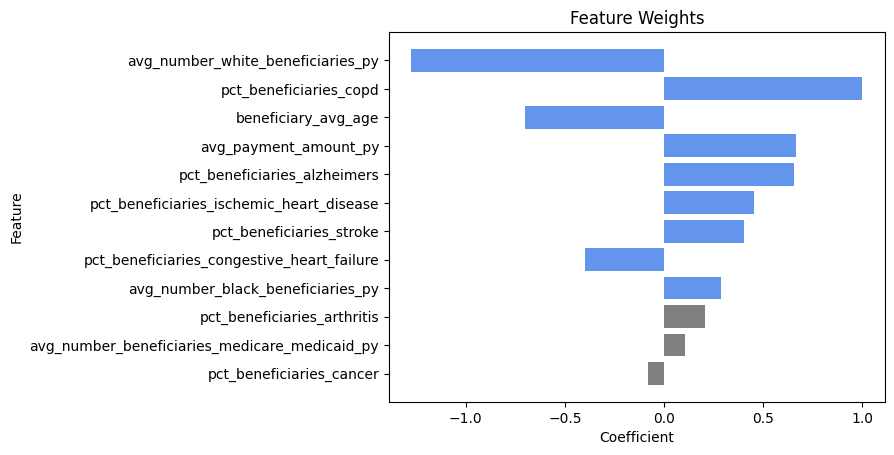

In [89]:
hf_df = df.query("condition_name == 'Heart Failure'").reset_index(drop=True)

numeric_cols = [
    "avg_payment_amount_py",
    "beneficiary_avg_age",
    "avg_number_white_beneficiaries_py",
    "avg_number_black_beneficiaries_py",
    "avg_number_beneficiaries_medicare_medicaid_py",
    # "avg_number_beneficiaries_medicare_only_py",
    "pct_beneficiaries_alzheimers",
    "pct_beneficiaries_cancer",
    "pct_beneficiaries_congestive_heart_failure",
    "pct_beneficiaries_copd",
    "pct_beneficiaries_ischemic_heart_disease",
    "pct_beneficiaries_arthritis",
    "pct_beneficiaries_stroke",
]


X_processed = process_features(hf_df, numeric_cols=numeric_cols, cat_cols=cat_cols)

fit_model, summary_scores = fit_linear_model_sm(
    X_processed,
    hf_df["readmission_rate"],
    model_name=model_name,
    race=True,
    summary_table=None,
)
plot_feature_weights_horizontal_sm(fit_model)

<Axes: >

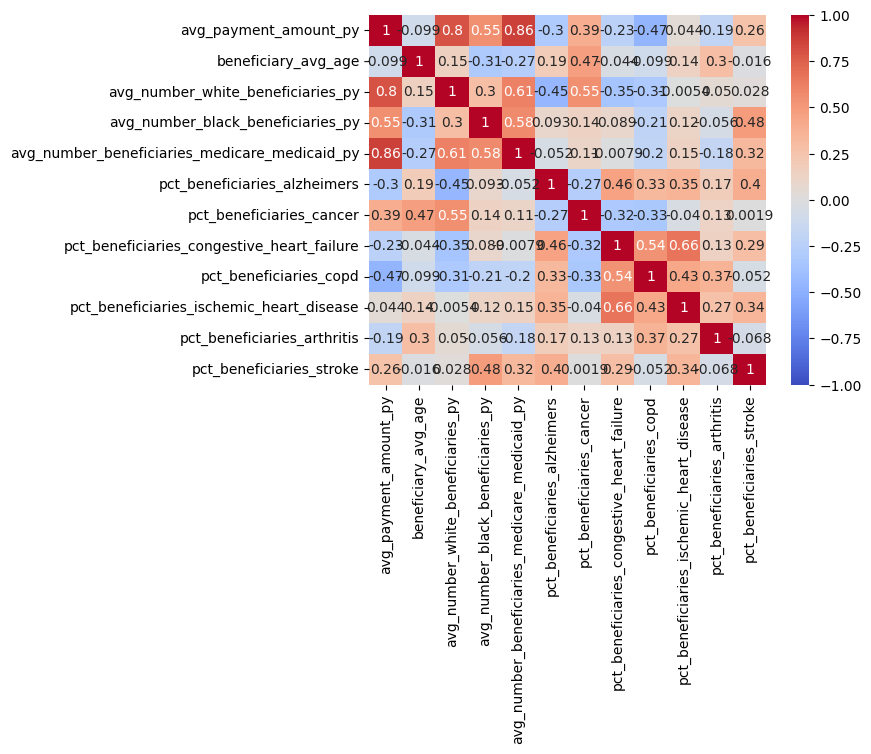

In [15]:
corr = X_processed.corr()
sns.heatmap(corr, cmap="coolwarm", annot=True, vmin=-1, vmax=1)

In [16]:
summary_scores

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       readmission_rate   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     56.30
Date:                Mon, 17 Jul 2023   Prob (F-statistic):          2.26e-114
Time:                        15:26:52   Log-Likelihood:                -4590.3
No. Observations:                1710   AIC:                             9207.
Df Residuals:                    1697   BIC:                             9277.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            21.6588      0.086    251.611      0.000      21.490      21.828
avg_payment_amount_py                             0.3131      0.325      0.964      0.335      -0.324       0.950
beneficiary_avg_age                              -0.7464      0.146     -5.117      0.000      -1.033      -0.460
avg_number_white_beneficiaries_py                -1.2404      0.210     -5.916      0.000      -1.652      -0.829
avg_number_black_beneficiaries_py                 0.4436      0.134      3.315      0.001       0.181       0.706
avg_number_beneficiaries_medicare_medicaid_py     0.2129      0.240      0.886      0.375      -0.258       0.684
pct_beneficiaries_alzheimers                      0.5439      0.146      3.722      0.000       0.257       0.831
pct_beneficiaries_cancer                         -0.0824      0.130     -0.635      0.526      -0.337       0.172
pct_beneficiaries_congestive_heart_failure       -0.4503      0.143     -3.159      0.002      -0.730      -0.171
pct_beneficiaries_copd                            0.8970      0.146      6.133      0.000       0.610       1.184
pct_beneficiaries_ischemic_heart_disease          0.5221      0.136      3.851      0.000       0.256       0.788
pct_beneficiaries_arthritis                       0.2653      0.106      2.509      0.012       0.058       0.473
pct_beneficiaries_stroke                          0.4227      0.119      3.538      0.000       0.188       0.657
==============================================================================
Omnibus:                       69.985   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.088
Skew:                           0.300   Prob(JB):                     3.42e-29
Kurtosis:                       4.216   Cond. No.                         8.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
get_significant_variables(fit_model)

Index(['beneficiary_avg_age', 'avg_number_white_beneficiaries_py',
       'avg_number_black_beneficiaries_py', 'pct_beneficiaries_alzheimers',
       'pct_beneficiaries_congestive_heart_failure', 'pct_beneficiaries_copd',
       'pct_beneficiaries_ischemic_heart_disease',
       'pct_beneficiaries_arthritis', 'pct_beneficiaries_stroke'],
      dtype='object')

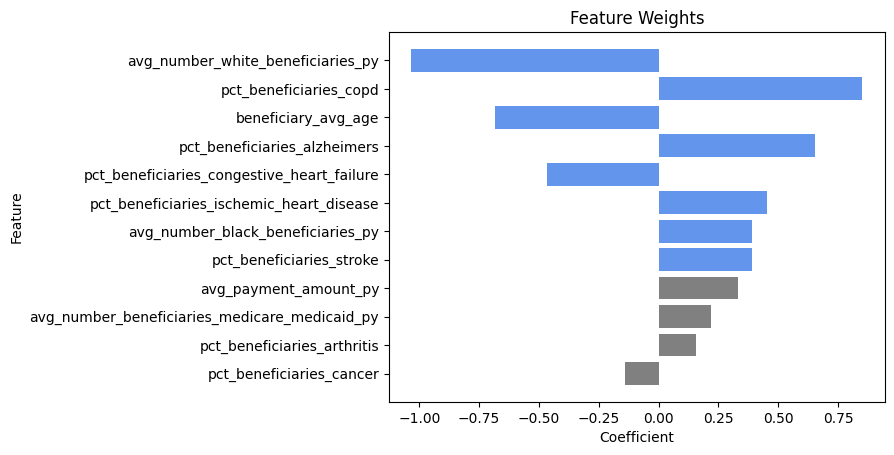

In [71]:
plot_feature_weights_horizontal_sm(fit_model)

In [49]:
hf_df = df.query("condition_name == 'Heart Failure'").reset_index(drop=True)

numeric_cols = [
    "avg_payment_amount_py",
    "beneficiary_avg_age",
    # "avg_number_white_beneficiaries_py",
    # "avg_number_black_beneficiaries_py",
    "avg_number_beneficiaries_medicare_medicaid_py",
    # "avg_number_beneficiaries_medicare_only_py",
    "pct_beneficiaries_alzheimers",
    "pct_beneficiaries_cancer",
    "pct_beneficiaries_congestive_heart_failure",
    "pct_beneficiaries_copd",
    "pct_beneficiaries_ischemic_heart_disease",
    "pct_beneficiaries_arthritis",
    "pct_beneficiaries_stroke",
]


X_processed = process_features(hf_df, numeric_cols=numeric_cols, cat_cols=cat_cols)

fit_model, summary_scores = fit_linear_model_sm(
    X_processed,
    hf_df["readmission_rate"],
    model_name="hf_wo_race",
    race=True,
    summary_table=None,
)

hf_wo_race test mse: 12.445, r2: 0.271


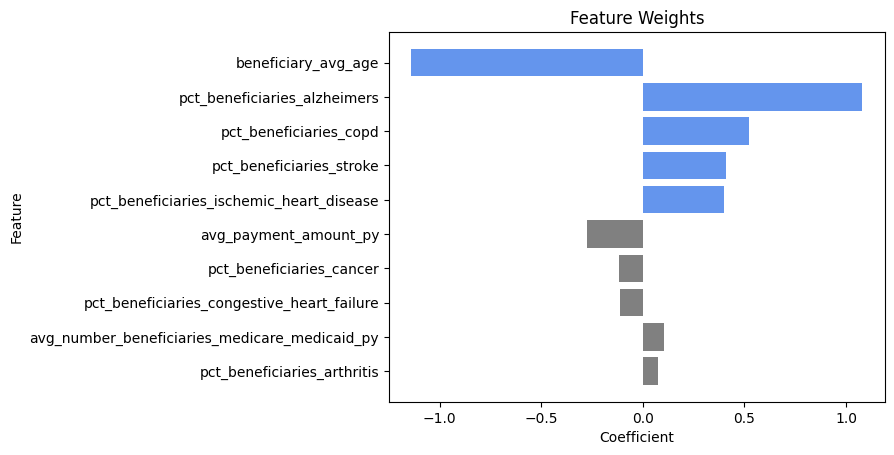

In [50]:
plot_feature_weights_horizontal_sm(fit_model)

## PN only

In [79]:
pn_df = df.query("condition_name == 'Pneumonia'").reset_index(drop=True)

X_processed = process_features(pn_df, numeric_cols=numeric_cols, cat_cols=cat_cols)

fit_model, summary_scores = fit_linear_model_sm(
    X_processed,
    pn_df["readmission_rate"],
    model_name=model_name,
    race=True,
    summary_table=None,
)

risk_vars_and_race test mse: 10.424, r2: 0.21


In [80]:
summary_scores

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       readmission_rate   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     38.28
Date:                Mon, 17 Jul 2023   Prob (F-statistic):           3.49e-85
Time:                        12:02:46   Log-Likelihood:                -4254.8
No. Observations:                1684   AIC:                             8538.
Df Residuals:                    1670   BIC:                             8614.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            17.2490      0.074    232.683      0.000      17.104      17.394
avg_payment_amount_py                             1.2011      0.326      3.689      0.000       0.563       1.840
beneficiary_avg_age                              -0.7341      0.123     -5.972      0.000      -0.975      -0.493
avg_number_white_beneficiaries_py                -0.3248      0.311     -1.044      0.296      -0.935       0.285
avg_number_black_beneficiaries_py                 0.3619      0.122      2.962      0.003       0.122       0.602
avg_number_beneficiaries_medicare_medicaid_py     0.0258      0.217      0.119      0.906      -0.400       0.452
avg_number_beneficiaries_medicare_only_py        -1.1130      0.399     -2.787      0.005      -1.896      -0.330
pct_beneficiaries_alzheimers                      0.5282      0.129      4.081      0.000       0.274       0.782
pct_beneficiaries_cancer                          0.4890      0.107      4.586      0.000       0.280       0.698
pct_beneficiaries_congestive_heart_failure       -0.0536      0.124     -0.433      0.665      -0.297       0.189
pct_beneficiaries_copd                            0.4213      0.128      3.283      0.001       0.170       0.673
pct_beneficiaries_ischemic_heart_disease          0.3649      0.117      3.112      0.002       0.135       0.595
pct_beneficiaries_arthritis                       0.1759      0.091      1.939      0.053      -0.002       0.354
pct_beneficiaries_stroke                          0.2329      0.106      2.205      0.028       0.026       0.440
==============================================================================
Omnibus:                       44.195   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.569
Skew:                           0.281   Prob(JB):                     4.27e-14
Kurtosis:                       3.750   Cond. No.                         14.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
get_significant_variables(fit_model)

Index(['avg_payment_amount_py', 'beneficiary_avg_age',
       'avg_number_black_beneficiaries_py',
       'avg_number_beneficiaries_medicare_only_py',
       'pct_beneficiaries_alzheimers', 'pct_beneficiaries_cancer',
       'pct_beneficiaries_copd', 'pct_beneficiaries_ischemic_heart_disease',
       'pct_beneficiaries_stroke'],
      dtype='object')

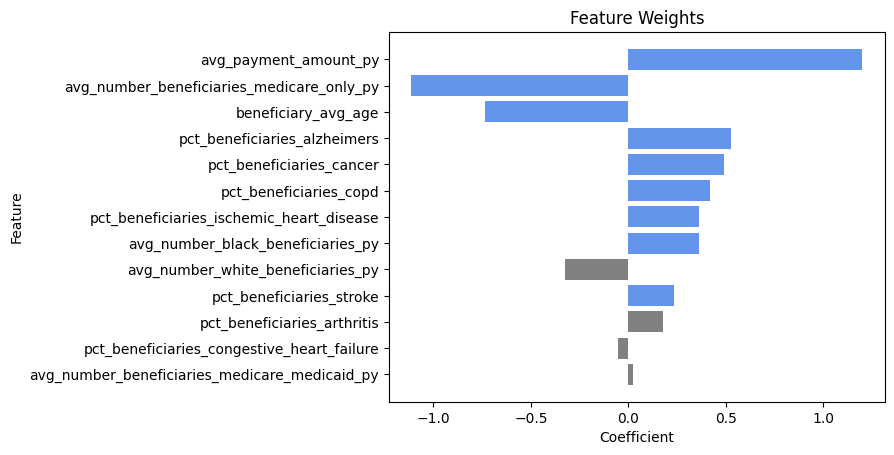

In [84]:
plot_feature_weights_horizontal_sm(fit_model)

## COPD only

In [85]:
copd_df = df.query(
    "condition_name == 'Chronic Obstructive Pulmonary Disease'"
).reset_index(drop=True)

X_processed = process_features(copd_df, numeric_cols=numeric_cols, cat_cols=cat_cols)

fit_model, summary_scores = fit_linear_model_sm(
    X_processed,
    copd_df["readmission_rate"],
    model_name=model_name,
    race=True,
    summary_table=None,
)

summary_scores

risk_vars_and_race test mse: 15.784, r2: 0.074


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       readmission_rate   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     22.89
Date:                Mon, 17 Jul 2023   Prob (F-statistic):           2.42e-50
Time:                        12:03:15   Log-Likelihood:                -3985.2
No. Observations:                1438   AIC:                             7998.
Df Residuals:                    1424   BIC:                             8072.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            20.3815      0.103    198.687      0.000      20.180      20.583
avg_payment_amount_py                             1.9181      0.437      4.387      0.000       1.060       2.776
beneficiary_avg_age                              -0.5984      0.179     -3.335      0.001      -0.950      -0.246
avg_number_white_beneficiaries_py                -0.3391      0.412     -0.823      0.411      -1.147       0.469
avg_number_black_beneficiaries_py                 0.0426      0.171      0.250      0.803      -0.292       0.377
avg_number_beneficiaries_medicare_medicaid_py     0.1031      0.298      0.346      0.729      -0.481       0.687
avg_number_beneficiaries_medicare_only_py        -2.2027      0.533     -4.132      0.000      -3.248      -1.157
pct_beneficiaries_alzheimers                      0.4991      0.178      2.797      0.005       0.149       0.849
pct_beneficiaries_cancer                          0.2880      0.152      1.889      0.059      -0.011       0.587
pct_beneficiaries_congestive_heart_failure       -0.0087      0.166     -0.053      0.958      -0.334       0.316
pct_beneficiaries_copd                            0.1224      0.182      0.673      0.501      -0.234       0.479
pct_beneficiaries_ischemic_heart_disease          0.0147      0.159      0.092      0.927      -0.297       0.327
pct_beneficiaries_arthritis                       0.0410      0.127      0.323      0.747      -0.208       0.290
pct_beneficiaries_stroke                          0.0608      0.138      0.442      0.659      -0.209       0.331
==============================================================================
Omnibus:                       28.983   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.992
Skew:                           0.321   Prob(JB):                     1.86e-07
Kurtosis:                       3.325   Cond. No.                         14.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [86]:
get_significant_variables(fit_model)

Index(['avg_payment_amount_py', 'beneficiary_avg_age',
       'avg_number_beneficiaries_medicare_only_py',
       'pct_beneficiaries_alzheimers'],
      dtype='object')

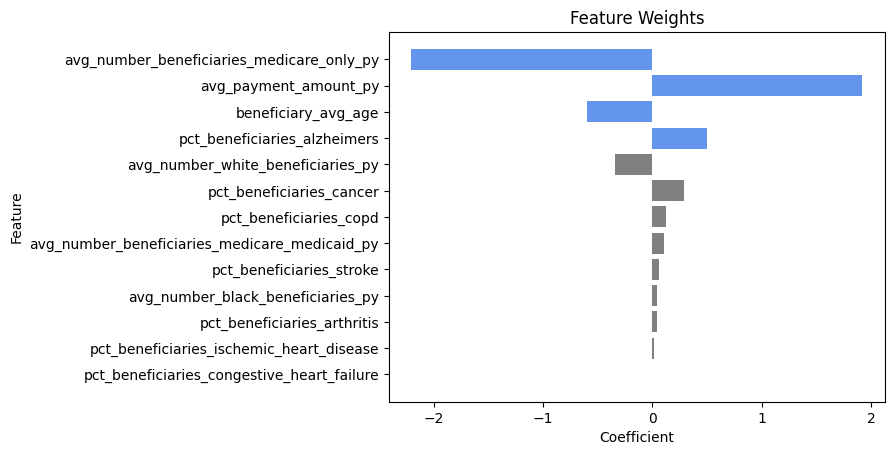

In [87]:
plot_feature_weights_horizontal_sm(fit_model)

## Univariate by condition

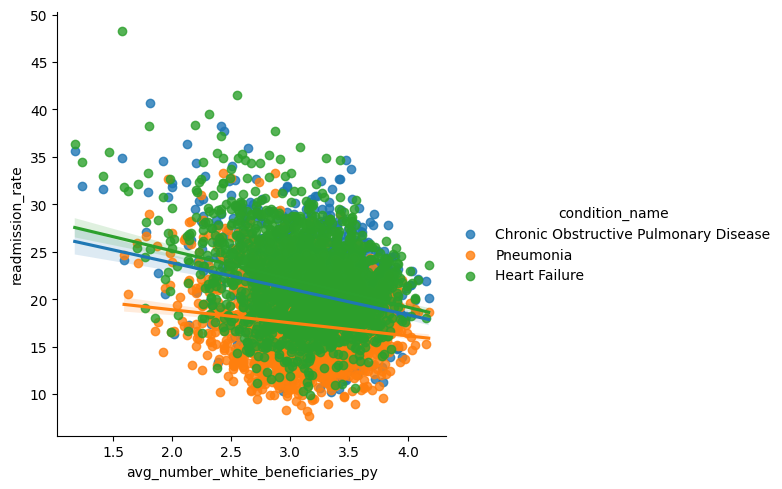

In [90]:
sns.lmplot(
    data=df,
    x="avg_number_white_beneficiaries_py",
    y="readmission_rate",
    hue="condition_name",
)

## Weighted average readmission rate

In [165]:
DATA_PATH = Path("/Users/jessbreda/Desktop/github/ca-sdoh/data")

cols_of_interest = [
    "facility_name",
    "condition_name",
    "number_of_readmissions",
    "number_of_discharges",
    "avg_payment_amount_py",
    "beneficiary_avg_age",
    "avg_number_white_beneficiaries_py",
    "avg_number_black_beneficiaries_py",
    "avg_number_beneficiaries_medicare_medicaid_py",
    "avg_number_beneficiaries_medicare_only_py",
    "pct_beneficiaries_alzheimers",
    "pct_beneficiaries_cancer",
    "pct_beneficiaries_congestive_heart_failure",
    "pct_beneficiaries_copd",
    "pct_beneficiaries_ischemic_heart_disease",
    "pct_beneficiaries_arthritis",
    "pct_beneficiaries_stroke",
]

df = pd.read_csv(
    (DATA_PATH / "obt_slim.csv"),
    usecols=cols_of_interest,
)

# drop nans
df.dropna(inplace=True)

# right skewed dist -> log transform
log_transform = [
    "avg_payment_amount_py",
    "avg_number_white_beneficiaries_py",
    "avg_number_black_beneficiaries_py",
    "avg_number_beneficiaries_medicare_medicaid_py",
    "avg_number_beneficiaries_medicare_only_py",
]

for col in log_transform:
    df[col] = np.log10(df[col])

In [173]:
# Calculate the total discharges for each hospital
total_hospital_discharges = df.groupby("facility_name")["number_of_discharges"].sum()

# Calculate the proportional weighted average readmission rate
proportional_weighted_average = (
    df["number_of_readmissions"] / df["number_of_discharges"]
) * (df["number_of_discharges"] / df["facility_name"].map(total_hospital_discharges))

# Add the proportional_weighted_average as a new column in the DataFrame
df["average_readmission_rate"] = proportional_weighted_average * 100

# Define the aggregation dictionary for columns you want to preserve
aggregation = {
    "average_readmission_rate": "first",
    "avg_payment_amount_py": "first",
    "beneficiary_avg_age": "first",
    "avg_number_white_beneficiaries_py": "first",
    "avg_number_black_beneficiaries_py": "first",
    "avg_number_beneficiaries_medicare_medicaid_py": "first",
    "avg_number_beneficiaries_medicare_only_py": "first",
    "pct_beneficiaries_alzheimers": "first",
    "pct_beneficiaries_cancer": "first",
    "pct_beneficiaries_congestive_heart_failure": "first",
    "pct_beneficiaries_copd": "first",
    "pct_beneficiaries_ischemic_heart_disease": "first",
    "pct_beneficiaries_arthritis": "first",
    "pct_beneficiaries_stroke": "first",
}

# If there are any numerical columns you want to aggregate (e.g., total number of discharges), you can use functions like "sum"
# aggregation["total_discharges"] = "sum"

# Collapse the DataFrame by grouping on "facility_id" and aggregating the other columns
collapsed_df = df.groupby("facility_name", as_index=False).agg(aggregation)

collapsed_df.drop("facility_name", axis=1, inplace=True)

In [174]:
collapsed_df.head()

,average_readmission_rate,avg_payment_amount_py,beneficiary_avg_age,avg_number_white_beneficiaries_py,avg_number_black_beneficiaries_py,avg_number_beneficiaries_medicare_medicaid_py,avg_number_beneficiaries_medicare_only_py,pct_beneficiaries_alzheimers,pct_beneficiaries_cancer,pct_beneficiaries_congestive_heart_failure,pct_beneficiaries_copd,pct_beneficiaries_ischemic_heart_disease,pct_beneficiaries_arthritis,pct_beneficiaries_stroke
0,18.367347,6.767454,75.288136,2.495891,1.797614,2.296665,2.301573,0.403641,0.123666,0.501569,0.347144,0.608286,0.527935,0.134338
1,4.616896,8.259375,72.329496,3.825377,2.546543,3.170702,3.775811,0.157935,0.170521,0.369903,0.219787,0.521797,0.414001,0.108467
2,5.548217,7.367543,77.703478,3.222066,1.894870,2.574031,3.180484,0.337521,0.166380,0.392408,0.261606,0.499273,0.562359,0.169687
3,6.689792,8.145775,76.148488,3.736894,3.004644,3.077186,3.753947,0.284383,0.191797,0.349420,0.216072,0.507079,0.530917,0.187830
4,8.293269,7.798046,75.056415,3.403292,1.937016,2.581210,3.418840,0.210351,0.150441,0.446081,0.281744,0.633966,0.508903,0.128474


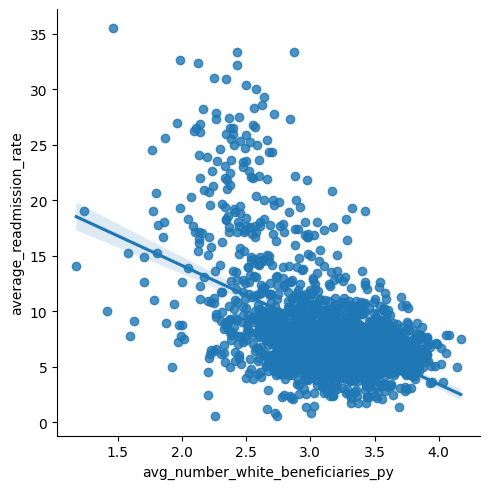

In [178]:
sns.lmplot(
    x="avg_number_white_beneficiaries_py",
    y="average_readmission_rate",
    data=collapsed_df,
)

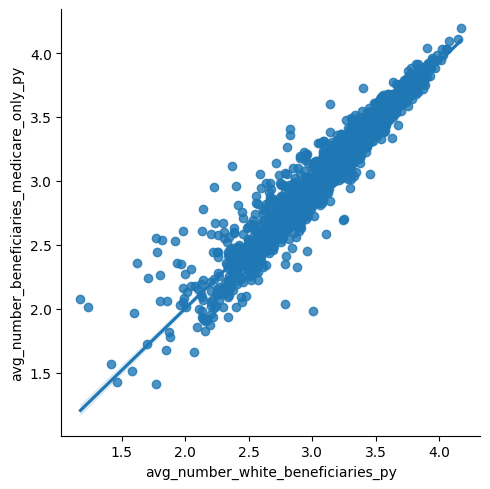

In [181]:
sns.lmplot(
    x="avg_number_white_beneficiaries_py",
    y="avg_number_beneficiaries_medicare_only_py",
    data=collapsed_df,
)

In [185]:
model_name = "hosp_weighted_w_race"
numeric_cols = [
    "avg_payment_amount_py",
    "beneficiary_avg_age",
    "avg_number_white_beneficiaries_py",
    "avg_number_black_beneficiaries_py",
    "avg_number_beneficiaries_medicare_medicaid_py",
    "pct_beneficiaries_alzheimers",
    "pct_beneficiaries_cancer",
    "pct_beneficiaries_congestive_heart_failure",
    "pct_beneficiaries_copd",
    "pct_beneficiaries_ischemic_heart_disease",
    "pct_beneficiaries_arthritis",
    "pct_beneficiaries_stroke",
]


X_processed = process_features(collapsed_df, numeric_cols=numeric_cols, cat_cols=None)

fit_model, summary_scores = fit_linear_model_sm(
    X_processed,
    collapsed_df["average_readmission_rate"],
    model_name=model_name,
    race=True,
    summary_table=None,
)

summary_scores

hosp_weighted_w_race test mse: 12.527, r2: 0.357


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     average_readmission_rate   R-squared:                       0.278
Model:                                  OLS   Adj. R-squared:                  0.273
Method:                       Least Squares   F-statistic:                     55.13
Date:                      Mon, 17 Jul 2023   Prob (F-statistic):          1.89e-112
Time:                              15:17:49   Log-Likelihood:                -4779.8
No. Observations:                      1734   AIC:                             9586.
Df Residuals:                          1721   BIC:                             9657.
Df Model:                                12                                         
Covariance Type:                  nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                             8.0644      0.092     87.777      0.000       7.884       8.245
avg_payment_amount_py                             0.6294      0.361      1.741      0.082      -0.079       1.338
beneficiary_avg_age                              -1.0985      0.153     -7.201      0.000      -1.398      -0.799
avg_number_white_beneficiaries_py                -1.3491      0.229     -5.886      0.000      -1.799      -0.900
avg_number_black_beneficiaries_py                -0.2737      0.142     -1.924      0.055      -0.553       0.005
avg_number_beneficiaries_medicare_medicaid_py    -1.4588      0.268     -5.450      0.000      -1.984      -0.934
pct_beneficiaries_alzheimers                      0.9130      0.156      5.836      0.000       0.606       1.220
pct_beneficiaries_cancer                          0.2054      0.133      1.539      0.124      -0.056       0.467
pct_beneficiaries_congestive_heart_failure       -0.0678      0.154     -0.441      0.660      -0.370       0.234
pct_beneficiaries_copd                           -0.3235      0.158     -2.046      0.041      -0.634      -0.013
pct_beneficiaries_ischemic_heart_disease          0.2117      0.144      1.470      0.142      -0.071       0.494
pct_beneficiaries_arthritis                       0.2422      0.112      2.162      0.031       0.022       0.462
pct_beneficiaries_stroke                         -0.2121      0.122     -1.739      0.082      -0.451       0.027
==============================================================================
Omnibus:                      620.684   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2691.818
Skew:                           1.674   Prob(JB):                         0.00
Kurtosis:                       8.103   Cond. No.                         9.28
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [187]:
get_significant_variables(fit_model)

Index(['beneficiary_avg_age', 'avg_number_white_beneficiaries_py',
       'avg_number_beneficiaries_medicare_medicaid_py',
       'pct_beneficiaries_alzheimers', 'pct_beneficiaries_copd',
       'pct_beneficiaries_arthritis'],
      dtype='object')

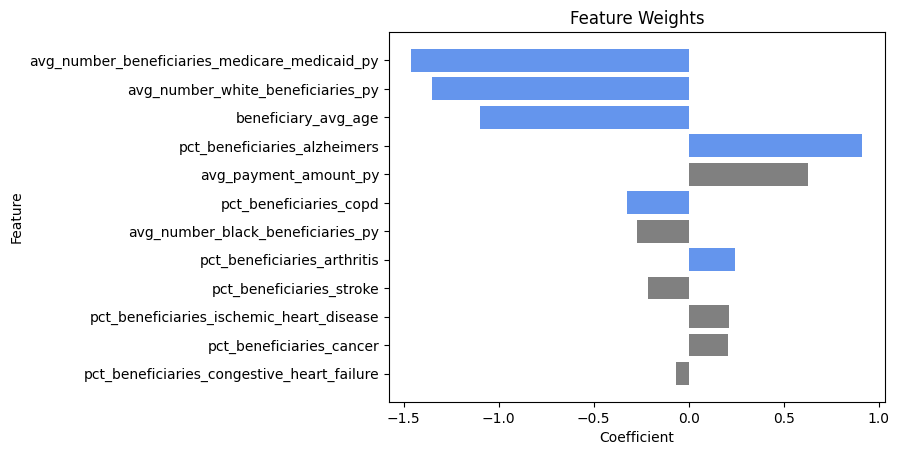

In [188]:
plot_feature_weights_horizontal_sm(fit_model)

<Axes: >

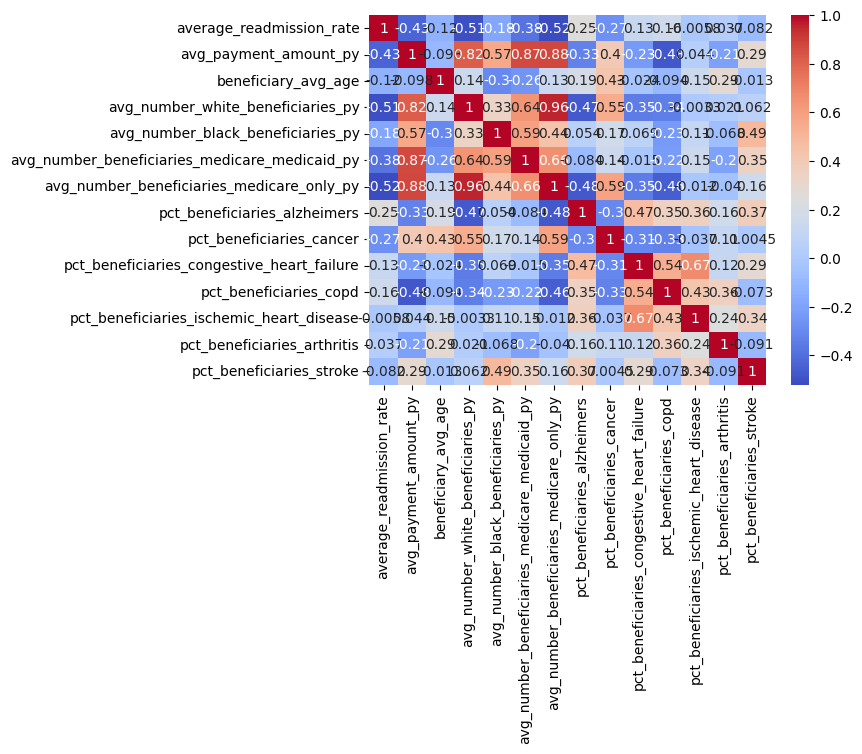

In [196]:
# correlation matrix
corr = collapsed_df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")

In [198]:
model_name = "hosp_weighted_wo_race"
numeric_cols = [
    "avg_payment_amount_py",
    "beneficiary_avg_age",
    # "avg_number_white_beneficiaries_py",
    # "avg_number_black_beneficiaries_py",
    "avg_number_beneficiaries_medicare_medicaid_py",
    "pct_beneficiaries_alzheimers",
    "pct_beneficiaries_cancer",
    "pct_beneficiaries_congestive_heart_failure",
    "pct_beneficiaries_copd",
    "pct_beneficiaries_ischemic_heart_disease",
    "pct_beneficiaries_arthritis",
    "pct_beneficiaries_stroke",
]


X_processed = process_features(collapsed_df, numeric_cols=numeric_cols, cat_cols=None)

fit_model, summary_scores = fit_linear_model_sm(
    X_processed,
    collapsed_df["average_readmission_rate"],
    model_name=model_name,
    race=False,
    summary_table=None,
)

summary_scores

hosp_weighted_wo_race test mse: 13.214, r2: 0.321


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     average_readmission_rate   R-squared:                       0.261
Model:                                  OLS   Adj. R-squared:                  0.257
Method:                       Least Squares   F-statistic:                     60.92
Date:                      Mon, 17 Jul 2023   Prob (F-statistic):          5.83e-106
Time:                              15:22:48   Log-Likelihood:                -4799.3
No. Observations:                      1734   AIC:                             9621.
Df Residuals:                          1723   BIC:                             9681.
Df Model:                                10                                         
Covariance Type:                  nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                             8.0750      0.093     86.974      0.000       7.893       8.257
avg_payment_amount_py                            -0.4729      0.319     -1.484      0.138      -1.098       0.152
beneficiary_avg_age                              -1.3390      0.125    -10.685      0.000      -1.585      -1.093
avg_number_beneficiaries_medicare_medicaid_py    -1.5997      0.270     -5.935      0.000      -2.128      -1.071
pct_beneficiaries_alzheimers                      1.2186      0.141      8.669      0.000       0.943       1.494
pct_beneficiaries_cancer                          0.0823      0.130      0.633      0.527      -0.173       0.337
pct_beneficiaries_congestive_heart_failure        0.0994      0.149      0.668      0.504      -0.193       0.391
pct_beneficiaries_copd                           -0.5689      0.149     -3.828      0.000      -0.860      -0.277
pct_beneficiaries_ischemic_heart_disease          0.2199      0.145      1.516      0.130      -0.065       0.504
pct_beneficiaries_arthritis                       0.0804      0.109      0.738      0.461      -0.133       0.294
pct_beneficiaries_stroke                         -0.2588      0.118     -2.190      0.029      -0.490      -0.027
==============================================================================
Omnibus:                      654.338   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2981.648
Skew:                           1.758   Prob(JB):                         0.00
Kurtosis:                       8.377   Cond. No.                         7.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

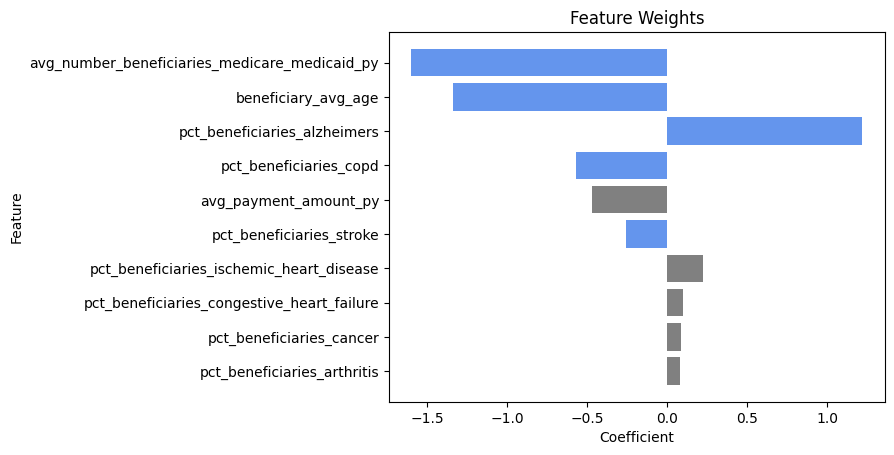

In [199]:
get_significant_variables(fit_model)
plot_feature_weights_horizontal_sm(fit_model)